In [86]:
import math
import numpy as np
import pandas as pd
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA
import pmdarima as pm
import time
import xgboost as xgb
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm

In [3]:
full_df = pd.read_csv('../data/m4/daily-train.csv')

def get_ts(full_df, index):
    df = full_df.iloc[index:index+1, 1:].transpose()
    df.columns = ['y']
    df = df[df['y'].notna()]
    return df

# df = get_ts(full_df, 6)
df = get_ts(full_df, 1)
df.tail()

,y
V1003,2978.0
V1004,2991.9
V1005,2995.3
V1006,3000.5
V1007,2968.5


In [35]:
def generate_serial_lags(feature_count):
    return list(range(1, feature_count + 1))

def get_features_from_lags(df, lag_count=7, lags=None, keep_y=False):
    """ Generates the feature (lags) that can than be used to forecast
        if the *lags* parameter is used, then the function will use the lags specified by this parameter and will
            ignore the lag_count parameter
        if lags is not used, the function will generate a sequence of features
            like [lag_1, lag_2, ..., lag_lag_count]
    """
    res = df[['y']].copy()
    
    if lags is None:
        lags = generate_serial_lags(lag_count)
    
    # The lags are computed for the *previous* value because when we forecast,
    # we cannot compute them for the current value
    res['previous'] = res['y'].shift(1)
    for lag in lags:
        res['lag_{}'.format(lag)] = res['previous'] - res['previous'].shift(lag)
    
    res['day'] = np.arange(res.shape[0]) % 7
    res['lag_to_predict'] = res['y'] - res['previous']
    
    # Ignore the first row, as it has no previous values, it cannot be predicted
    if keep_y:
        columns_to_drop = ['previous']
    else:
        columns_to_drop = ['previous', 'y']
    return res[1:].drop(columns_to_drop, axis=1)

def get_future_lags(df, feature_count=7):
#     df.iloc[-1:].shift(1, axis=1)
    res = df[['y']].copy()
    lags = ['lag_{}'.format(lag) for lag in range(1, feature_count + 1)]
    
    for i, lag in enumerate(lags):
        res[lag] = res['y'] - res['y'].shift(i + 1)
    
    res['day'] = np.arange(res.shape[0]) % 7
    
    return res

# f = get_features_from_lags(df)
f = get_features_from_lags(df,lags=[1, 2, 4, 10])
f
# f.drop('residuals', axis=1)
# get_future_lags(df)


,lag_1,lag_2,lag_4,lag_10,day,lag_to_predict
V3,NaN,NaN,NaN,NaN,1,-24.370
V4,-24.370,NaN,NaN,NaN,2,4.637
V5,4.637,-19.733,NaN,NaN,3,161.564
V6,161.564,166.201,NaN,NaN,4,96.183
V7,96.183,257.747,238.014,NaN,5,3.658
...,...,...,...,...,...,...
V1003,270.530,1761.113,1687.417,2637.019,0,-1238.472
V1004,-1238.472,-967.942,319.046,354.323,1,-221.396
V1005,-221.396,-1459.868,301.245,-6.523,2,0.163
V1006,0.163,-221.233,-1189.175,1023.760,3,1480.812


In [151]:
def train_xgb(df, in_sample_validation=False):
    xgb_reg_params = {
    #         'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.1)),
        'learning_rate': 1,
        'max_depth':        40,
        'early_stopping_rounds': 10000,
        'eval_metric': 'rmse',
        'n_estimators': 100,
    }

    if in_sample_validation:
        # Validate against in sample data
        train = df
        validation = df
    else:
        # Validate against out of sample
        train = df[:-50]
        validation = df[-50:]

    X_train = train.drop('lag_to_predict', axis=1)
    y_train = train[['lag_to_predict']]


    reg = xgb.XGBRegressor(**xgb_reg_params)
    eval_set = [(validation.drop('lag_to_predict', axis=1), validation[['lag_to_predict']])]
    reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    return reg

def predict_xgb(df, model):
    return model.predict(df)

lgs = get_features_from_lags(df)
train_df = lgs[:-10]
test_df = lgs[-10:].copy()

model = train_xgb(train_df)
test_df['yhat'] = predict_xgb(test_df.drop(['lag_to_predict'], axis=1), model)
print("MSE:", mean_squared_error(test_df['lag_to_predict'], test_df['yhat']))
# # test_df

MSE: 571.1541344538322


In [160]:
def get_xgboost_insample_error(df, model, features=None):
#     lags = get_features_from_lags(df, lags=features, keep_y=True)
    lags = df.copy()
    lags['lag_hat'] = predict_xgb(lags.drop(['lag_to_predict'], axis=1), model)
    return {
        "insample_mse": mean_squared_error(lags['y'], lags['yhat']),
        "insample_mape": mean_absolute_percentage_error(lags['y'], lags['yhat'])
    }



In [159]:
get_xgboost_insample_error(lgs, model)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,day,lag_to_predict,lag_hat
V3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.1,0.300000
V4,0.1,NaN,NaN,NaN,NaN,NaN,NaN,2,9.9,10.875000
V5,9.9,10.0,NaN,NaN,NaN,NaN,NaN,3,2.1,1.466667
V6,2.1,12.0,12.1,NaN,NaN,NaN,NaN,4,-3.5,-5.062500
V7,-3.5,-1.4,8.5,8.6,NaN,NaN,NaN,5,-7.3,-5.062500
...,...,...,...,...,...,...,...,...,...,...
V1003,-41.3,-71.4,-76.3,-69.8,-55.7,-59.9,-70.1,0,14.1,-2.850000
V1004,14.1,-27.2,-57.3,-62.2,-55.7,-41.6,-45.8,1,13.9,16.674999
V1005,13.9,28.0,-13.3,-43.4,-48.3,-41.8,-27.7,2,3.4,-15.683334
V1006,3.4,17.3,31.4,-9.9,-40.0,-44.9,-38.4,3,5.2,-32.775002


In [163]:
# Code to compute forecasts and errors

loop_over_df = full_df.drop('V1', axis=1)[:10]

lags_to_test = [
    [1],
    # Last week
    [1, 2, 3, 4, 5, 6, 7],
    [1, 2, 3, 4, 5, 6, 7, 8],
    # Last week + 2 & 3 weeks ago
    [1, 2, 3, 4, 5, 6, 7, 14, 21],
    # Past 4 weeks complete
    [i for i in range(1, 29)],
    # Past week + 1 year ago
    [1, 2, 3, 4, 5, 6, 7, 365],
    # Past week + 1 year ago (with one week)
    [1, 2, 3, 4, 5, 6, 7, 365, 366, 367, 368, 369, 370, 371],
    # Daily, weekly & yearly seasonality
    [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365],
    [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 367, 368, 369, 370, 371],
]

def get_predictions_with_features(df, features=None):
    lags = get_features_from_lags(df, lags=features)

    # Reserve last observations for testing
    train_df = lags[:-10]
    test_df = lags[-10:].copy()
    
    # Train and predict the lags
    model = train_xgb(train_df)
    test_df['yhat'] = predict_xgb(test_df.drop(['lag_to_predict'], axis=1), model)
    
    insample = get_xgboost_insample_error(train_df, model)

    results = {
        'mse': mean_squared_error(test_df['lag_to_predict'], test_df['yhat']),
        'mape': mean_absolute_percentage_error(test_df['lag_to_predict'], test_df['yhat'])
    }
    
    results = {**results, **insample}
    return results
    
def get_xgboost_insample_error(df, model, features=None):
    lags = df.copy()
    lags['lag_hat'] = predict_xgb(lags.drop(['lag_to_predict'], axis=1), model)
    return {
        "insample_mse": mean_squared_error(lags['lag_to_predict'], lags['lag_hat']),
        "insample_mape": mean_absolute_percentage_error(lags['lag_to_predict'], lags['lag_hat'])
    }

# This defines the error measure used to sort the results (i.e. whichone is better)
error_measure = "mape"
    
    
results = []
for i in tqdm(range(loop_over_df.shape[0])):
    current_df = get_ts(full_df, i)

    ts_errors = []
    for lag_set in lags_to_test:
        if max(lag_set) > current_df.shape[0]:
            print("Too many lags: {} (more than available in dataset)".format(max(lag_set)))
        start_time = time.time()
        errors = {'time series index': i, 'lags': str(lag_set)}
        errors = {**errors, **get_predictions_with_features(current_df, lag_set)}
        errors['time'] = time.time() - start_time
        ts_errors.append(errors)
    # Sort this list by smallest error first
    ts_errors = sorted(ts_errors, key=lambda x: x[error_measure])
    # Add the ranking
    for i, row in enumerate(ts_errors):
        ts_errors[i]['rank'] = i + 1
    results.extend(ts_errors)
res_df = pd.DataFrame(results)

  0%|          | 0/10 [00:00<?, ?it/s]

Too many lags: 365 (more than available in dataset)
Too many lags: 371 (more than available in dataset)
Too many lags: 365 (more than available in dataset)
Too many lags: 371 (more than available in dataset)
Too many lags: 365 (more than available in dataset)
Too many lags: 371 (more than available in dataset)
Too many lags: 365 (more than available in dataset)
Too many lags: 371 (more than available in dataset)
Too many lags: 365 (more than available in dataset)
Too many lags: 371 (more than available in dataset)
Too many lags: 365 (more than available in dataset)
Too many lags: 371 (more than available in dataset)


In [164]:
res_df

,time series index,lags,mse,mape,insample_mse,insample_mape,time,rank
0,0,[1],123.635382,1.051254,24.154131,7.859297e+13,0.358533,1
1,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",109.253511,1.051631,13.503646,1.014630e+13,0.749371,2
2,0,"[1, 2, 3, 4, 5, 6, 7]",101.854520,1.072460,13.729485,1.101383e+13,0.621088,3
3,0,"[1, 2, 3, 4, 5, 6, 7, 14, 21]",144.229954,1.193690,13.622591,1.199451e+13,0.657660,4
4,0,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365]",84.350582,1.375154,13.535528,1.105155e+13,0.698435,5
...,...,...,...,...,...,...,...,...
85,9,[1],835.425265,1.306164,274.125511,1.698190e+12,0.430074,5
86,9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",735.317974,1.319139,152.182364,1.698190e+12,0.608864,6
87,9,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",831.398578,2.009877,147.602982,1.358552e+12,0.516007,7
88,9,"[1, 2, 3, 4, 5, 6, 7, 8]",1193.704457,2.157410,70.769608,1.698190e+11,0.564287,8


In [146]:
# See how many times each lag set has performed
ranking = res_df.groupby(['lags', 'rank']).count().reset_index().drop(['mse', 'mape', 'time'], axis=1)
ranking.rename(columns={'time series index': 'count'})
ranking

,lags,rank,time series index
0,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",1,299
1,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",2,506
2,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",3,505
3,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",4,432
4,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",5,414
...,...,...,...
76,[1],5,457
77,[1],6,378
78,[1],7,358
79,[1],8,364


In [147]:
# Check the lag sets that appeared most times in the top 2
ranking[ranking['rank'].isin([1, 2])].groupby(['lags']).sum().reset_index()[['lags', 'time series index']].sort_values('time series index', ascending=False)
# ranking[ranking['rank'].isin([1, 2])]

,lags,time series index
8,[1],1322
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1136
7,"[1, 2, 3, 4, 5, 6, 7]",1060
1,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365]",958
6,"[1, 2, 3, 4, 5, 6, 7, 8]",949
2,"[1, 2, 3, 4, 5, 6, 7, 14, 21]",909
0,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365, 366, 36...",805
4,"[1, 2, 3, 4, 5, 6, 7, 365]",720
3,"[1, 2, 3, 4, 5, 6, 7, 365, 366, 367, 368, 369,...",595


In [148]:
res_df.head()

,time series index,lags,mse,mape,time,rank
0,0,[1],123.635382,1.051254,0.346158,1
1,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",109.253511,1.051631,0.701602,2
2,0,"[1, 2, 3, 4, 5, 6, 7]",101.854520,1.072460,0.388991,3
3,0,"[1, 2, 3, 4, 5, 6, 7, 14, 21]",144.229954,1.193690,0.590945,4
4,0,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 365]",84.350582,1.375154,0.749102,5


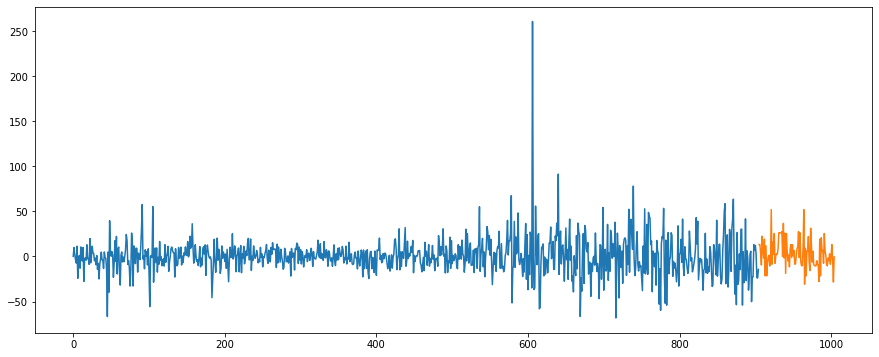

In [102]:
# exploratory eda
df = get_ts(full_df, 1)

lgs = get_features_from_lags(df)

test_size = 100
train_df = lgs[:-test_size]
test_df = lgs[-test_size:].copy()

model = train_xgb(train_df)
test_df['yhat'] = predict_xgb(test_df.drop(['lag_to_predict'], axis=1), model)

x = np.arange(df.shape[0] - 1)
plt.figure(figsize=(15,6))
plt.plot(x[:-test_size], train_df['lag_to_predict'])
plt.plot(x[-test_size:], test_df['yhat'])
plt.show()